In [1]:
import cudf
import glob

# Path to dataset
dataset_path = "/kaggle/input/yellow-cab-nyc/"

# Filter files only for August (08), September (09), October (10), and November (11)
selected_files = [file for file in glob.glob(dataset_path + "*.parquet") if any(m in file for m in ["-08", "-09", "-10", "-11"])]

# Read and concatenate only selected files
df_gpu = cudf.concat([cudf.read_parquet(file) for file in selected_files])

# Display first few rows
df_gpu.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-09-01 00:05:51,2024-09-01 00:45:03,1,9.80,1,N,138,48,1,47.8,10.25,0.5,13.30,6.94,1.0,79.79,2.5,1.75
1,1,2024-09-01 00:59:35,2024-09-01 01:03:43,1,0.50,1,N,140,141,1,5.1,3.50,0.5,3.00,0.00,1.0,13.10,2.5,0.00
2,2,2024-09-01 00:25:00,2024-09-01 00:34:37,2,2.29,1,N,238,152,2,13.5,1.00,0.5,0.00,0.00,1.0,16.00,0.0,0.00
3,2,2024-09-01 00:31:00,2024-09-01 00:46:52,1,5.20,1,N,93,130,1,24.7,1.00,0.5,4.55,0.00,1.0,31.75,0.0,0.00
4,2,2024-09-01 00:11:57,2024-09-01 00:30:41,2,2.26,1,N,79,231,1,17.0,1.00,0.5,4.40,0.00,1.0,26.40,2.5,0.00


In [2]:
print(df_gpu['tpep_pickup_datetime'].min(), df_gpu['tpep_pickup_datetime'].max())

2002-12-31T22:17:43.000000 2024-12-01T22:04:33.000000


In [3]:
# Convert to datetime format in GPU
df_gpu['tpep_pickup_datetime'] = cudf.to_datetime(df_gpu['tpep_pickup_datetime'])

# Keep only data from 2024
df_gpu = df_gpu[(df_gpu['tpep_pickup_datetime'] >= "2024-08-01") & 
                (df_gpu['tpep_pickup_datetime'] <= "2024-11-30")]

In [4]:
print(df_gpu['tpep_pickup_datetime'].min(), df_gpu['tpep_pickup_datetime'].max())

2024-08-01T00:00:01.000000 2024-11-30T00:00:00.000000


In [5]:
# Drop duplicates (GPU)
df_gpu = df_gpu.drop_duplicates()

In [6]:
# Fill missing passenger count with 1 (most common value)
df_gpu['passenger_count'] = df_gpu['passenger_count'].fillna(1)

# Fill RatecodeID with 1 (Standard rate, most common)
df_gpu['RatecodeID'] = df_gpu['RatecodeID'].fillna(1)

# Fill store_and_fwd_flag with 'N' (default for modern taxis)
df_gpu['store_and_fwd_flag'] = df_gpu['store_and_fwd_flag'].fillna("N")

# Fill congestion surcharge with 0 (assume no surcharge if missing)
df_gpu['congestion_surcharge'] = df_gpu['congestion_surcharge'].fillna(0)

# Fill Airport_fee with 0 (assume no airport charge if missing)
df_gpu['Airport_fee'] = df_gpu['Airport_fee'].fillna(0)

In [13]:
# Extract hour, day, weekday, month
df_gpu['pickup_hour'] = df_gpu['tpep_pickup_datetime'].dt.hour
df_gpu['pickup_day'] = df_gpu['tpep_pickup_datetime'].dt.day
df_gpu['pickup_weekday'] = df_gpu['tpep_pickup_datetime'].dt.weekday
df_gpu['pickup_month'] = df_gpu['tpep_pickup_datetime'].dt.month

# Flag peak hours (7-9 AM & 5-7 PM)
df_gpu['is_peak_hour'] = df_gpu['pickup_hour'].isin([7, 8, 9, 17, 18, 19])

# Flag weekends (Saturday = 5, Sunday = 6)
df_gpu['is_weekend'] = df_gpu['pickup_weekday'] >= 5

In [9]:
# Calculate trip duration in minutes
df_gpu['trip_duration'] = (df_gpu['tpep_dropoff_datetime'] - df_gpu['tpep_pickup_datetime']).dt.seconds / 60

# Remove unrealistic durations (less than 1 min or more than 3 hours)
df_gpu = df_gpu[(df_gpu['trip_duration'] > 1) & (df_gpu['trip_duration'] < 180)]

In [10]:
# Compute average trip speed (miles per minute)
df_gpu['trip_speed'] = df_gpu['trip_distance'] / df_gpu['trip_duration']

# Remove extreme speed values (unrealistic speeds)
df_gpu = df_gpu[(df_gpu['trip_speed'] > 0.1) & (df_gpu['trip_speed'] < 2.0)]

In [29]:
# Compute fare per mile
df_gpu['fare_per_mile'] = df_gpu['fare_amount'] / df_gpu['trip_distance']

# Remove unrealistic values
df_gpu = df_gpu[(df_gpu['fare_per_mile'] > 0.5) & (df_gpu['fare_per_mile'] < 20)]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker  

### 1. Taxi Demand by Hour of the Day

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


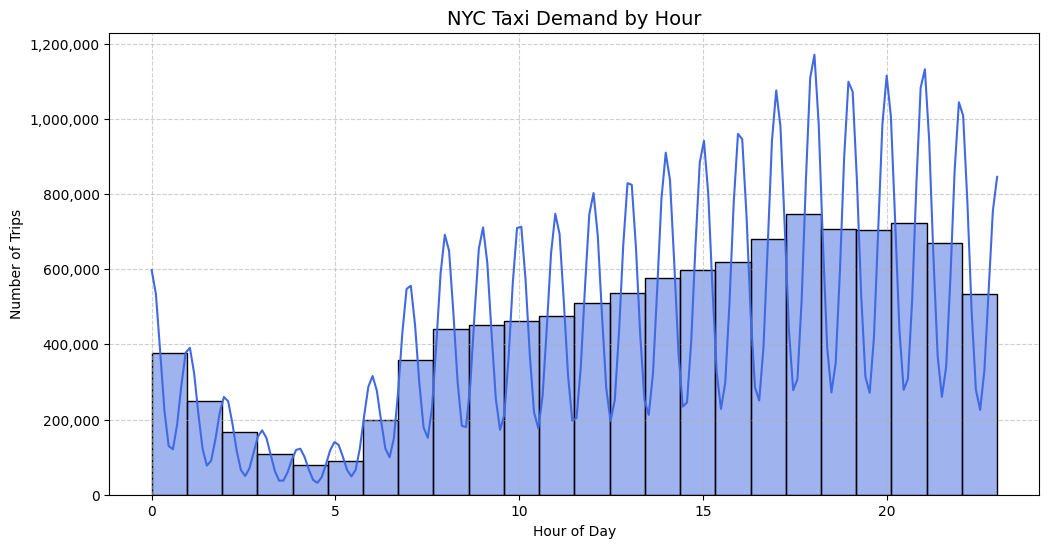

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.histplot(df_gpu['pickup_hour'].to_pandas(), bins=24, kde=True, color="royalblue", edgecolor="black")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.title("NYC Taxi Demand by Hour", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

🔍 Key Observations
1. Early Morning (12 AM - 6 AM)
- Demand is high at midnight. Drops significantly between 2 AM - 5 AM, the slowest period.
2. Morning Commute (6 AM - 10 AM)
- Sharp increase in rides from 6 AM as people commute to work. Demand stabilizes after 10 AM.
3. Afternoon to Evening Peak (12 PM - 9 PM)
- Steady increase in rides from noon, peaking between 4 PM - 8 PM (evening rush hour). Peak taxi demand occurs at 5-7 PM when people return home.
4. Late Night Demand (9 PM - 12 AM)
- Remains high due to nightlife, events, and airport travel.

### 2. Which Locations Have the Most Demand?

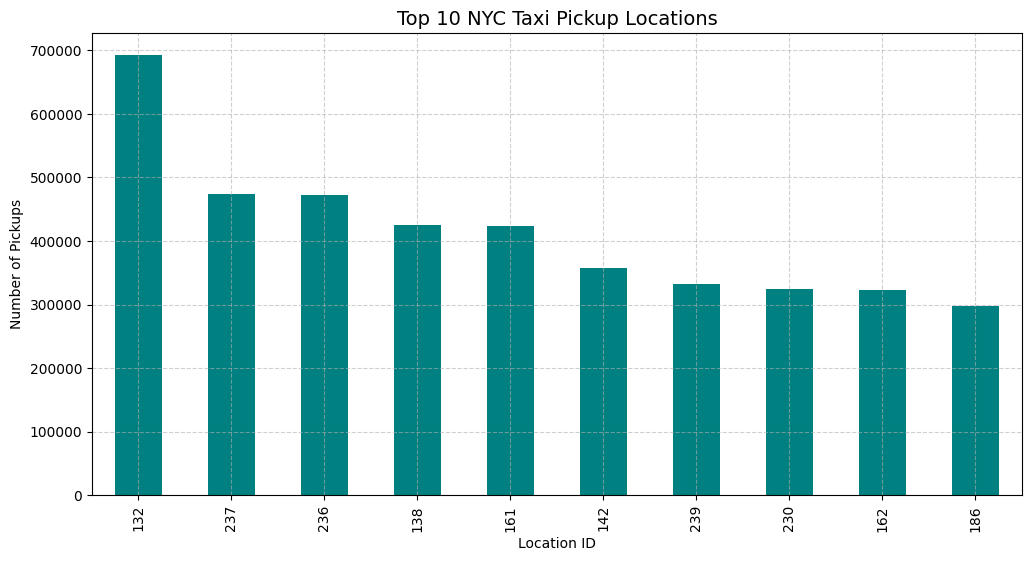

In [15]:
plt.figure(figsize=(12, 6))
df_gpu['PULocationID'].to_pandas().value_counts().head(10).plot(kind="bar", color="teal")
plt.title("Top 10 NYC Taxi Pickup Locations", fontsize=14)
plt.xlabel("Location ID")
plt.ylabel("Number of Pickups")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

This chart shows the busiest pickup spots in NYC. Some areas see way more taxi activity than others—why?

🔹 Hot Zones for Taxis:
- High pickup volume at Location 132 suggests a major transit hub or tourist hotspot.
- Other top locations (237, 236, 138, 161) could be business districts, airports, or nightlife areas.

### 3. Trip Duration & Speed Analysis

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


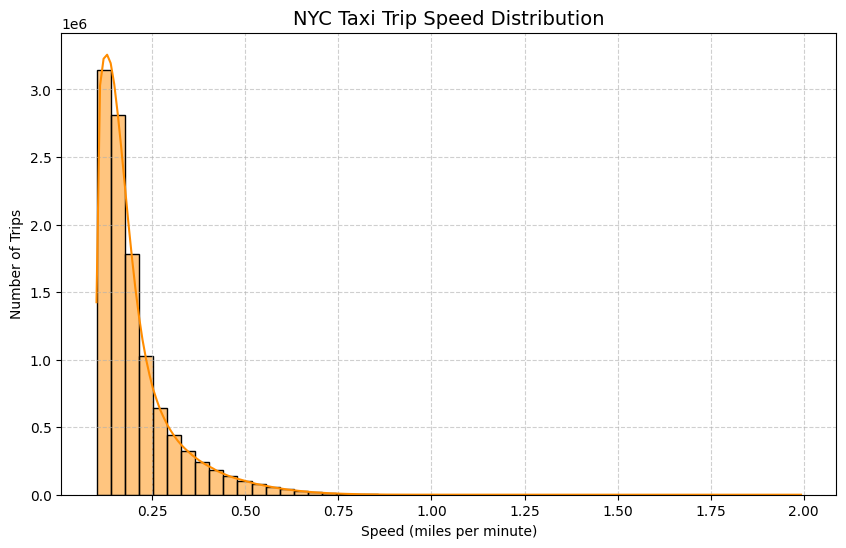

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df_gpu['trip_speed'].to_pandas(), bins=50, kde=True, color="darkorange")
plt.title("NYC Taxi Trip Speed Distribution", fontsize=14)
plt.xlabel("Speed (miles per minute)")
plt.ylabel("Number of Trips")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

This chart shows how fast NYC taxis actually move on average.

Key Observations:
- Most taxis travel under 0.5 miles per minute (~30 mph).
- A sharp drop-off after 0.5 miles/min suggests very few high-speed trips.
- Traffic congestion keeps most trips slow, likely under 15-25 mph in busy areas.

### 4. Pricing Insights – Does Distance Always Mean Higher Fare?

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


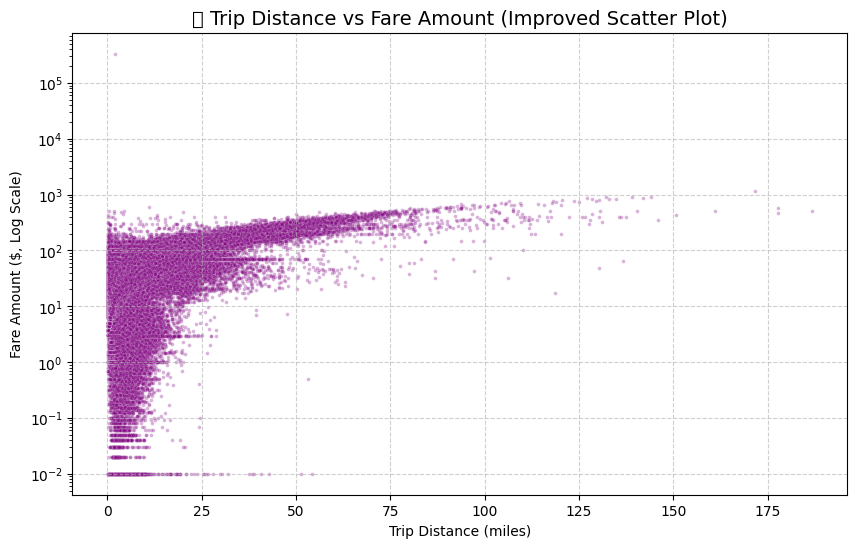

In [21]:
plt.figure(figsize=(10, 6))

# Scatter plot with transparency & small markers
sns.scatterplot(x=df_gpu['trip_distance'].to_pandas(), 
                y=df_gpu['fare_amount'].to_pandas(), 
                alpha=0.3, s=7, color="purple")

# Use log scale for fare to fix "one-line" issue
plt.yscale('log')

plt.title("Trip Distance vs Fare Amount (Improved Scatter Plot)", fontsize=14)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($, Log Scale)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

This scatter plot shows how fare changes with trip distance, using a log scale for better visibility.

Key Observations:
- Short trips have high variability → Some very expensive short rides, likely due to minimum fares, tolls, or congestion pricing.
- Beyond ~10 miles, fares stabilize and follow a linear trend.
- Few extreme long-distance rides go over 100 miles, possibly airport or out-of-city trips.

### 5. Payment Method Trends

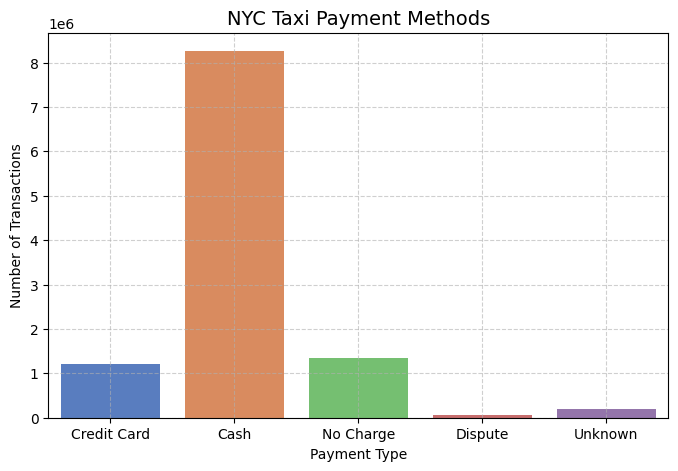

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df_gpu['payment_type'].to_pandas(), palette="muted")
plt.title("NYC Taxi Payment Methods", fontsize=14)
plt.xlabel("Payment Type")
plt.ylabel("Number of Transactions")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Credit Card", "Cash", "No Charge", "Dispute", "Unknown"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### 6. Passenger Count Analysis – Do Taxis Usually Carry Single Riders or Groups?

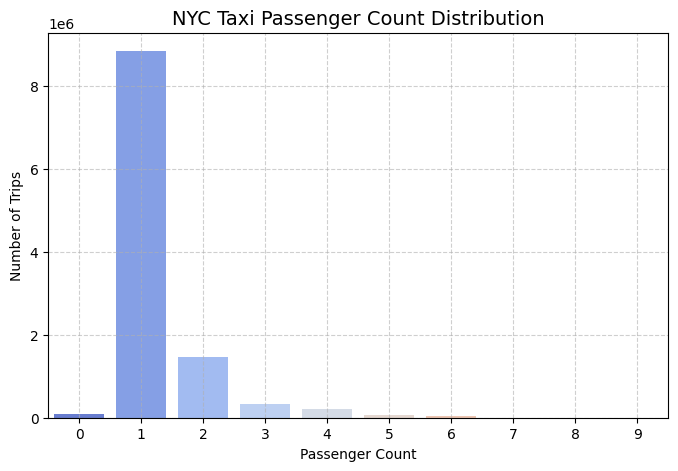

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df_gpu['passenger_count'].to_pandas(), palette="coolwarm")
plt.title("NYC Taxi Passenger Count Distribution", fontsize=14)
plt.xlabel("Passenger Count")
plt.ylabel("Number of Trips")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### 7. How Do Different Rate Codes Affect Pricing?

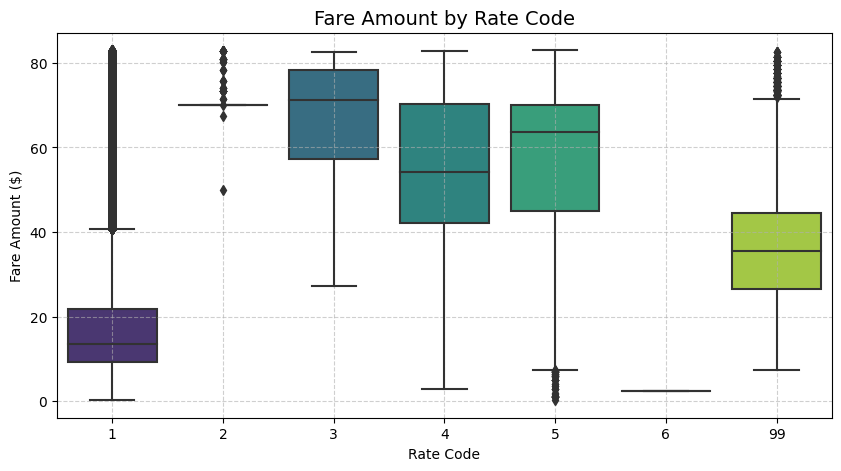

In [33]:
# Remove extreme fare outliers (keep 99th percentile)
df_filtered = df_gpu[df_gpu['fare_amount'] < df_gpu['fare_amount'].quantile(0.99)]

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_filtered['RatecodeID'].to_pandas(), 
            y=df_filtered['fare_amount'].to_pandas(), 
            palette="viridis")

plt.title("Fare Amount by Rate Code", fontsize=14)
plt.xlabel("Rate Code")
plt.ylabel("Fare Amount ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Key Observations:
- Rate Code 1 (Standard Rate) has the widest range, but fares are mostly under $30.
- Rate Codes 2, 3, and 4 (likely airport & flat fares) have higher median fares (~$50-$80).
- Rate Code 5 (negotiated fares) shows a lot of variance, with some trips being very cheap.
- Rate Code 99 (miscellaneous category) has fares mostly between $20-$40.

### 8. Impact of Congestion Surcharge on Fares

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


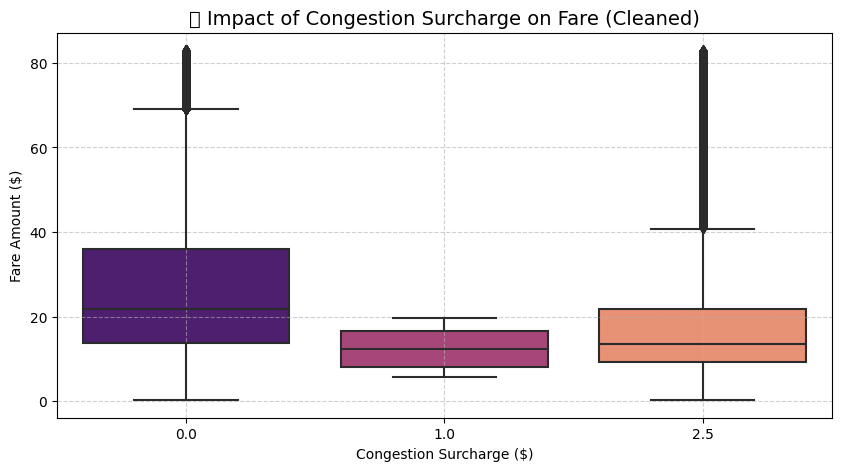

In [32]:
# Remove extreme fare outliers (keep 99th percentile)
df_filtered = df_gpu[df_gpu['fare_amount'] < df_gpu['fare_amount'].quantile(0.99)]

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_filtered['congestion_surcharge'].to_pandas(), 
            y=df_filtered['fare_amount'].to_pandas(), 
            palette="magma")

plt.title("🚦 Impact of Congestion Surcharge on Fare (Cleaned)", fontsize=14)
plt.xlabel("Congestion Surcharge ($)")
plt.ylabel("Fare Amount ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Key Observations:
- Higher surcharges ($2.50) lead to higher fares, but not drastically.
- Most rides with no surcharge (0$) still have varied fares, suggesting other pricing factors at play.
- Surcharges of $1.00 seem to result in more consistent fares, possibly due to standard pricing rules.

### 9. Fare Per Mile – Are Short Trips More Expensive?



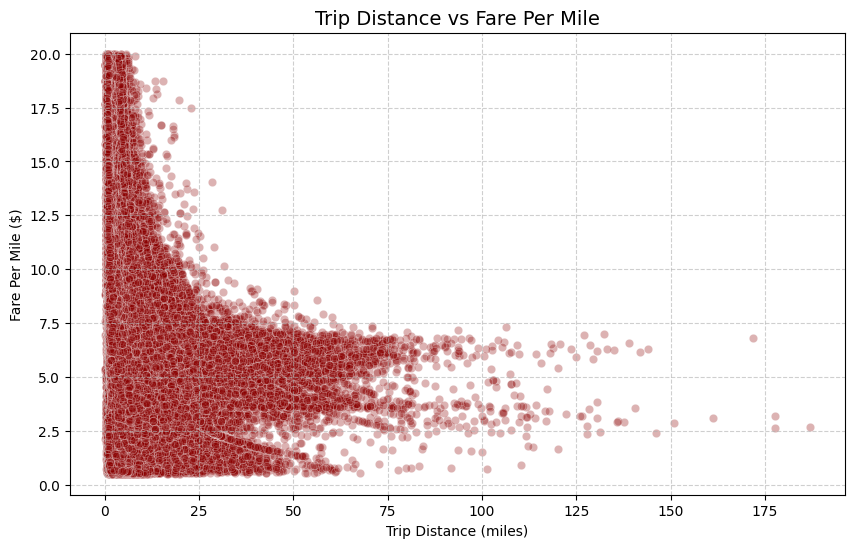

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_gpu['trip_distance'].to_pandas(), y=df_gpu['fare_per_mile'].to_pandas(), alpha=0.3, color="darkred")
plt.title("Trip Distance vs Fare Per Mile", fontsize=14)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Per Mile ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Key Observations:
- Short trips have a very high fare per mile, often exceeding $10-$15 per mile due to base fare and minimum charges.
- As trip distance increases, fare per mile drops significantly, stabilizing around $2-$3 per mile.
- Some long trips still show a higher per-mile rate, possibly due to tolls, surcharges, or premium pricing.